In [1]:
import os

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

In [2]:
# Sorting code from Meng

from random import choice

def permuteOrder(df,axis,switch = 0):
    penaltyMat = np.zeros((df.shape[0],df.shape[1]))
    for i in range(penaltyMat.shape[0]):
        for j in range(penaltyMat.shape[1]):
            penaltyMat[i,j] = np.abs(i-(df.shape[0])/(df.shape[1])*j)**0.5
    if axis == 0:
        sort = df.index.values.copy()
    elif axis == 1:
        sort = df.columns.values.copy()
    dfCopy = df.values.copy()
#     print(dfCopy)
    for i in range(df.shape[int(axis)]):
        penalty = np.full((df.shape[int(axis)]),np.inf)
        for j in range(len(penalty)):
            tempMat = dfCopy.copy()
            if axis == 0:
                tempMat[[i, j],:] = tempMat[[j, i],:]
            elif axis == 1:
                tempMat[:,[i, j]] = tempMat[:,[j, i]]
            penalty[j] = sum(sum(tempMat*penaltyMat))
        idx = np.argmin(penalty)
        if not idx == i:                
            switch += 1
        if axis == 0:
            dfCopy[[i, idx], :] = dfCopy[[idx, i], :];
        elif axis == 1:
            dfCopy[:,[i, idx]] = dfCopy[:,[idx, i]];
        else:
            print('bad axis {}'.format(axis))
        sort[[i, idx]] = sort[[idx, i]]
    return switch,sort

def runPermutation(df, axis = 'Both', maxIter = 100,maxTrys = 5):
    iterations = 0
    trys = 0
    sortedDF = df.copy(deep=True)
    while iterations < maxIter:
        if axis == 'Both':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            switch,columnSort = permuteOrder(sortedDF,1,switch)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
        if axis == 'Rows':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,:].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                 iterations = maxIter
        if axis == 'Columns':
            switch,columnSort = permuteOrder(sortedDF,1)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[:,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
    return sortedDF, sortedDF.index, sortedDF.columns

In [14]:
def train_nn_gene_exp_classifier(adata, label_column, genes):
    '''Train a nueral net classifier using the gene expressions.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    Y = np.array(adata.obs[label_column])
    
    nnc = MLPClassifier(max_iter = 500)
    nnc.fit(X, Y)
    return nnc

def predict_classes(classifier, adata, prediction_column, genes):
    '''Predict the classes of cells using a trained classifier.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    adata.obs[prediction_column] = classifier.predict(X)
    
def plot_cluster_correspondance(adata_ref, adata_query, ref_cluster_column, query_cluster_column,
                                prediction_column='predicted_classes', genes=None):
    '''Plot the correspondance between clusters from two data sets.'''
    # Make a copy of the query data set
    adata_query = adata_query.copy()
    
    # Use the shared genes for predictions if the gene set is not specified
    if genes is None:
        genes = list(set(adata_ref.var.index).intersection(set(adata_query.var.index)))
        
    # Train a classifier
    print(f'Train a classifier using {len(genes)} genes and {adata_ref.shape[0]} cells.')
    nnc = train_nn_gene_exp_classifier(adata_ref, ref_cluster_column, genes)
    
    # Make predictions
    print('Predict cell types.')
    predict_classes(nnc, adata_query, prediction_column, genes)
    
    # Count predictions
    prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
    prediction_counts['count'] = 1
    
    predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)
    predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
    fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
    
    # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    plt.xlabel(ref_cluster_column) 
    plt.ylabel(query_cluster_column)
    plt.show()
    
    return fractions_sorted
    

In [4]:
MOp_MERFISH_preprocessed_for_integration_file = '../test_data/preprocessed_integration_test_data/MOp_MERFISH_preprocessed_for_integration.h5ad'
adata_mer = sc.read_h5ad(MOp_MERFISH_preprocessed_for_integration_file)
MOp_sn_seq_preprocessed_for_integration_file = '../test_data/preprocessed_integration_test_data/MOp_sn-seq_preprocessed_for_integration.h5ad'
adata_sn_mg = sc.read_h5ad(MOp_sn_seq_preprocessed_for_integration_file)

Train a classifier using 254 genes and 148637 cells.
Predict cell types.


<ipython-input-98-d33153dc9895>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


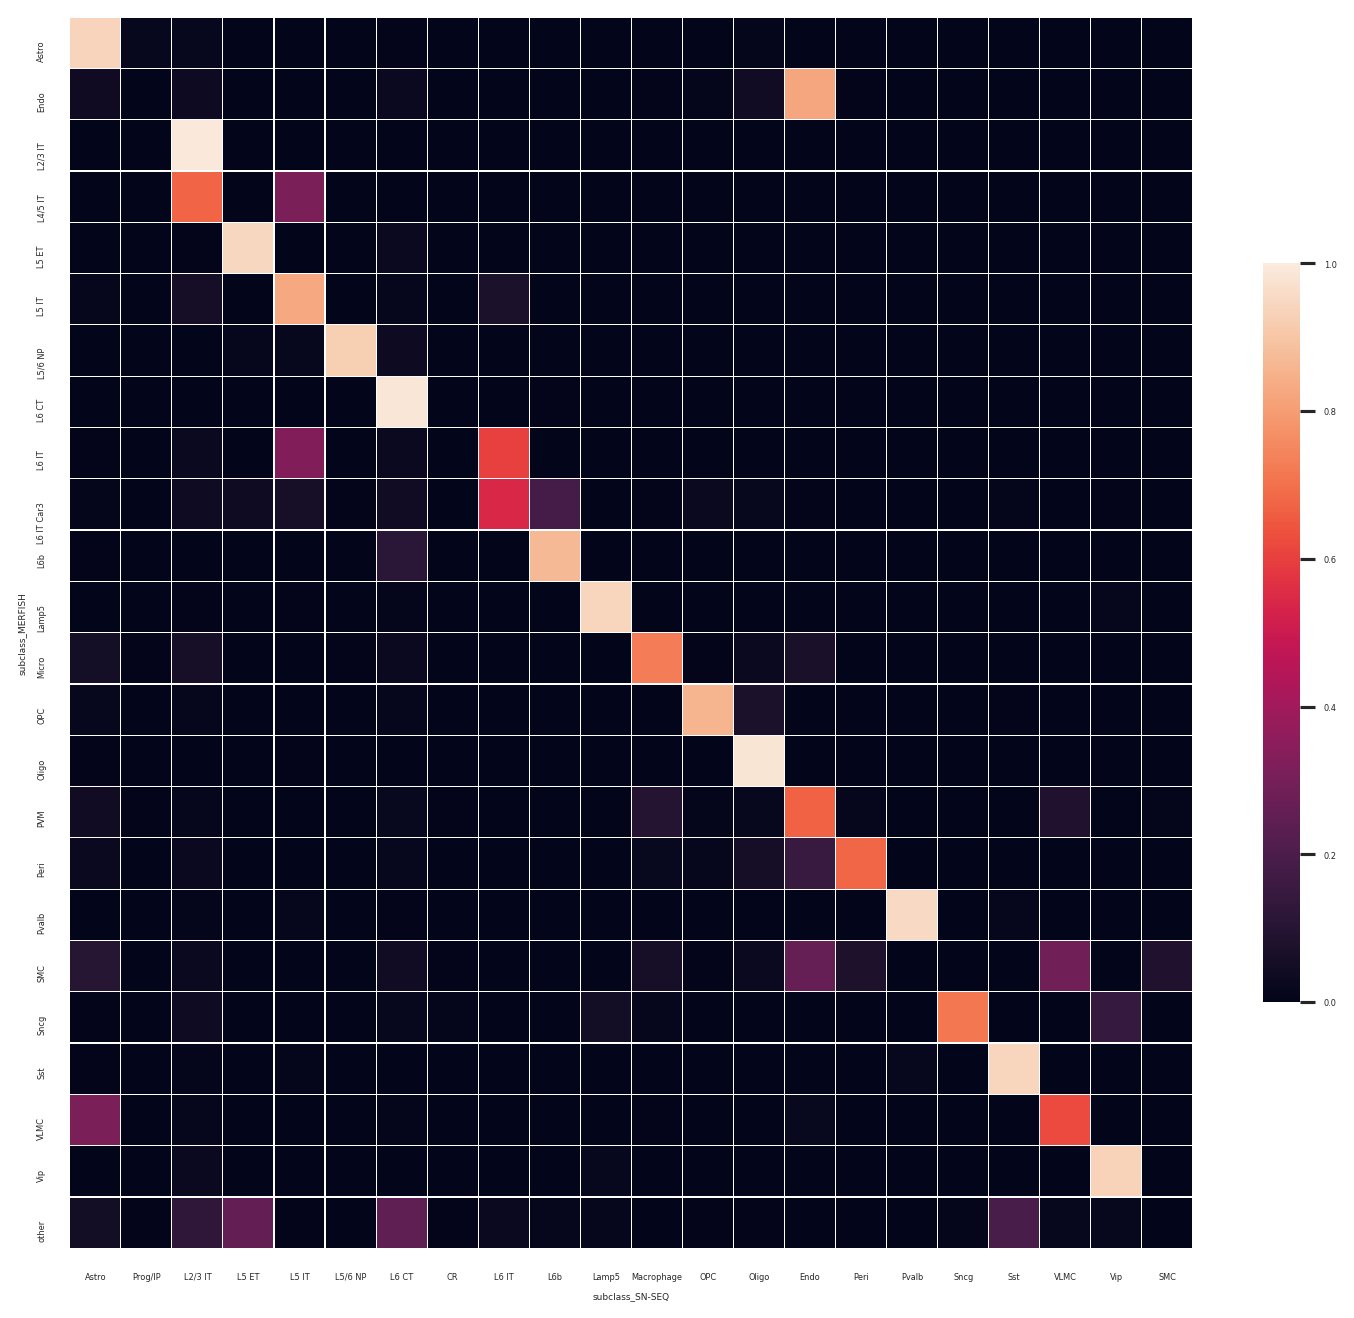

In [100]:
%%time
plot_cluster_correspondance(adata_sn_mg, adata_mer, 'subclass_SN-SEQ', 'subclass_MERFISH')

Train a classifier using 254 genes and 280186 cells.
Predict cell types.


<ipython-input-14-e93ae79d23af>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


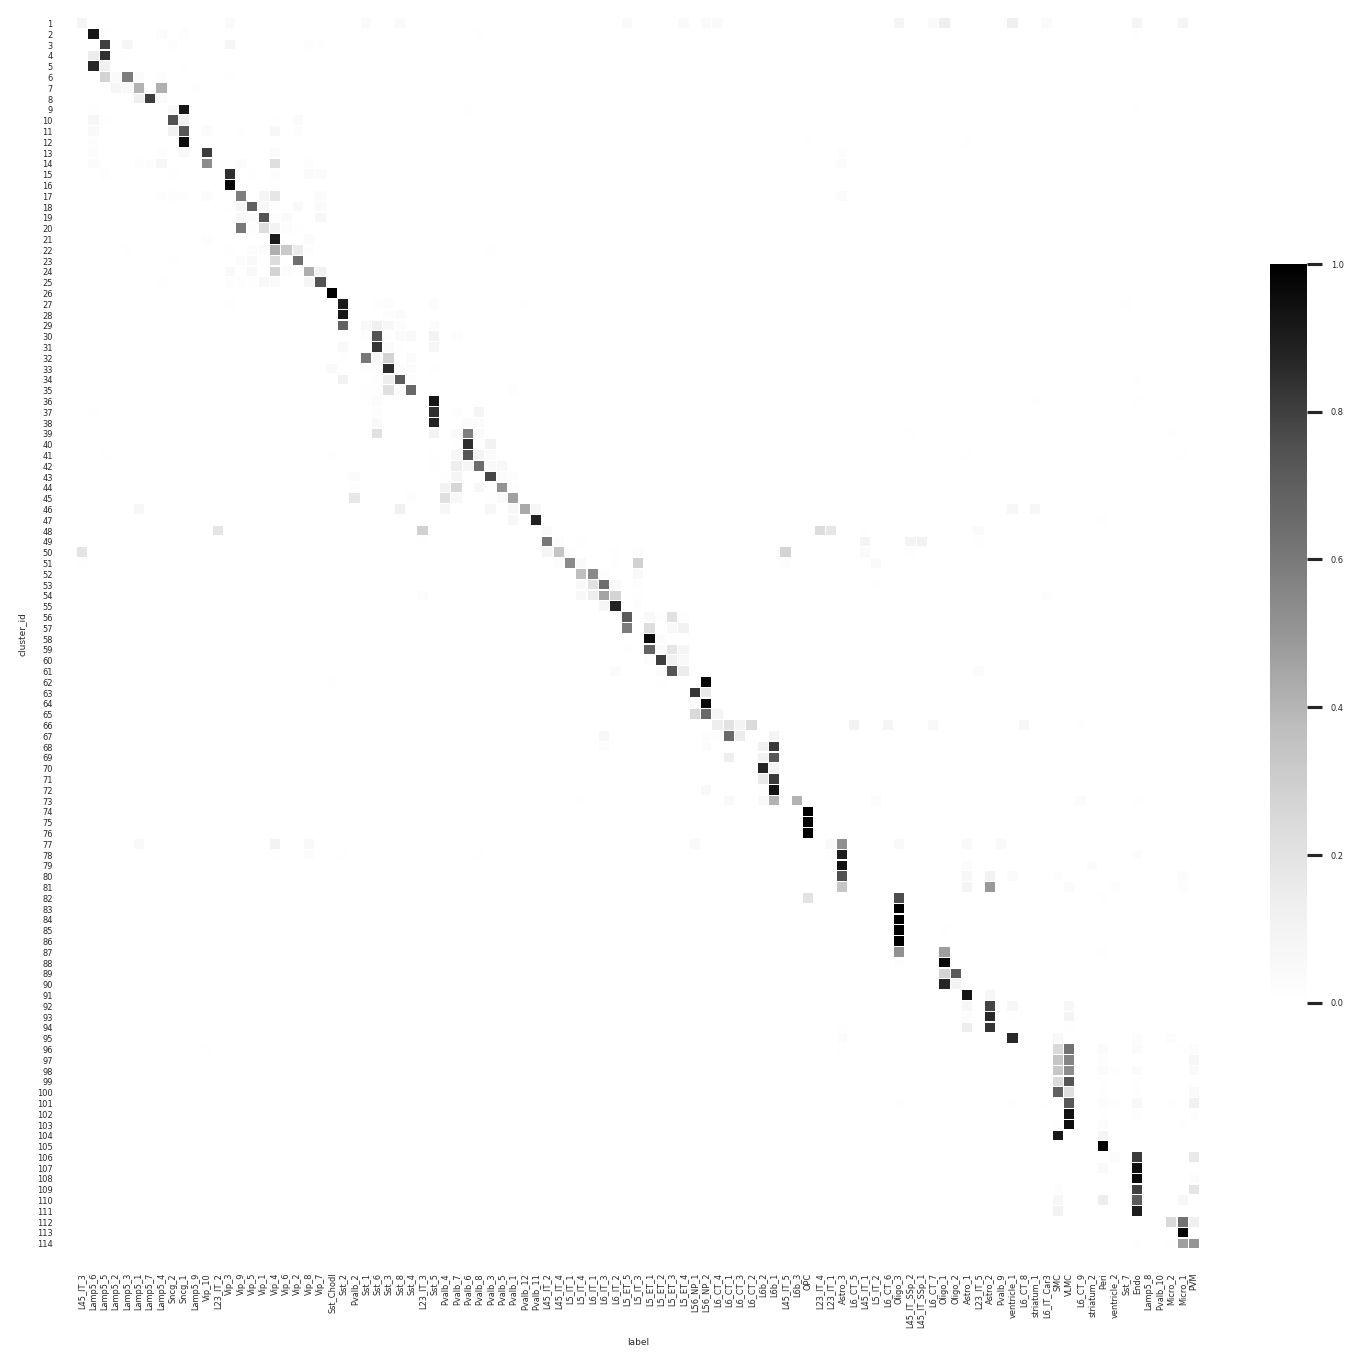

CPU times: user 4h 54min 27s, sys: 9h 17min 8s, total: 14h 11min 36s
Wall time: 18min 35s


In [17]:
%%time
fractions_sorted = plot_cluster_correspondance(adata_mer, adata_sn_mg, 'label', 'cluster_id')

In [29]:
# Map the SN-seq clusters to the MERFISH clusters
cluster_map = {}
cluster_map_int = {}
id_max = fractions_sorted.idxmax(axis=1, skipna=True)

for i in id_max.index:
    cluster_map[str(i)] = id_max[i]
    cluster_map_int[int(i)] = id_max[i]
    
print(cluster_map)
print(cluster_map_int)

{'1': 'Oligo_1', '2': 'Lamp5_6', '3': 'Lamp5_5', '4': 'Lamp5_5', '5': 'Lamp5_6', '6': 'Lamp5_3', '7': 'Lamp5_4', '8': 'Lamp5_7', '9': 'Sncg_1', '10': 'Sncg_2', '11': 'Sncg_1', '12': 'Sncg_1', '13': 'Vip_10', '14': 'Vip_10', '15': 'Vip_3', '16': 'Vip_3', '17': 'Vip_9', '18': 'Vip_5', '19': 'Vip_1', '20': 'Vip_9', '21': 'Vip_4', '22': 'Vip_4', '23': 'Vip_2', '24': 'Vip_8', '25': 'Vip_7', '26': 'Sst_Chodl', '27': 'Sst_2', '28': 'Sst_2', '29': 'Sst_2', '30': 'Sst_6', '31': 'Sst_6', '32': 'Sst_1', '33': 'Sst_3', '34': 'Sst_8', '35': 'Sst_4', '36': 'Sst_5', '37': 'Sst_5', '38': 'Sst_5', '39': 'Pvalb_6', '40': 'Pvalb_6', '41': 'Pvalb_6', '42': 'Pvalb_8', '43': 'Pvalb_3', '44': 'Pvalb_5', '45': 'Pvalb_1', '46': 'Pvalb_12', '47': 'Pvalb_11', '48': 'L23_IT_3', '49': 'L45_IT_2', '50': 'L45_IT_4', '51': 'L5_IT_1', '52': 'L6_IT_1', '53': 'L6_IT_3', '54': 'L6_IT_3', '55': 'L6_IT_2', '56': 'L5_ET_5', '57': 'L5_ET_5', '58': 'L5_ET_1', '59': 'L5_ET_1', '60': 'L5_ET_2', '61': 'L5_ET_3', '62': 'L56_NP_2'

In [33]:
print([i for i in list(fractions_sorted.columns) if i[0] == 'L' and i[1] != 'a'])

['L45_IT_3', 'L23_IT_2', 'L23_IT_3', 'L45_IT_2', 'L45_IT_4', 'L5_IT_1', 'L5_IT_4', 'L6_IT_1', 'L6_IT_3', 'L6_IT_2', 'L5_ET_5', 'L5_IT_3', 'L5_ET_1', 'L5_ET_2', 'L5_ET_3', 'L5_ET_4', 'L56_NP_1', 'L56_NP_2', 'L6_CT_4', 'L6_CT_1', 'L6_CT_3', 'L6_CT_2', 'L6b_2', 'L6b_1', 'L45_IT_5', 'L6b_3', 'L23_IT_4', 'L23_IT_1', 'L6_CT_5', 'L45_IT_1', 'L5_IT_2', 'L6_CT_6', 'L45_IT_SSp_2', 'L45_IT_SSp_1', 'L6_CT_7', 'L23_IT_5', 'L6_CT_8', 'L6_IT_Car3', 'L6_CT_9']
